## Introduction

This notebook provides code for mixup contrastive learning. The method is illustrated on the gunpoint dataset. The dataset used in this notebook is the gunpoint dataset. But more are available. See https://github.com/alan-turing-institute/sktime/tree/master/sktime/datasets/data for more info.

The first two code block clones the sktime Github repo and loads the necessary packages.

In [1]:
#@title Clone Git repos

# !pip install sktime

In [1]:
#@title Load packages and data


import torch as th
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt


from IPython.display import clear_output
from sktime.datasets import load_gunpoint
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import json
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split

def to_np(x):
    return x.cpu().detach().numpy()

## Load data and create Pytorch dataset

The following two code block loads the data, converts it to numpy array, before wrapping it in the Pytorch dataset class.

In [3]:
# replace ' with " in file
with open("archive/endomondoHR.json", mode="r") as file:
    with open("archive/endomondoHR_pre.json", mode="w") as output_file:
        for index, line in enumerate(file):
            training = json.loads(line.replace("'", '"'))
            output_file.write(json.dumps(training).replace("\n", " ") + "\n")

In [4]:
N = 3000
data_raw = []

In [5]:
speed_list = []
altitude_list = []
heart_rate_list = []
longitude_list = []
latitude_list = []
sport_list = []

In [6]:
with open("archive/endomondoHR_pre.json", mode="r") as file:
    for index, line in tqdm(enumerate(file)):
        if len(data_raw) >= N:
            break
        training = json.loads(line)
        if "speed" not in training.keys() or len(training["speed"]) != 500 \
            or len(training["altitude"]) != 500 or len(training["heart_rate"]) != 500 \
                  or len(training["longitude"]) != 500 or len(training["latitude"]) != 500:
            continue
        speed_list.append(training["speed"])
        altitude_list.append(training["altitude"])
        heart_rate_list.append(training["heart_rate"])
        longitude_list.append(training["longitude"])
        latitude_list.append(training["latitude"])
        sport_list.append(training["sport"])
        data_raw.append(training)

21570it [00:11, 1868.21it/s]


In [7]:
print(pd.Series(sport_list).nunique())
index_2_sport = {index: sport for index, sport in enumerate(pd.Series(sport_list).unique())}
sport_2_index = {sport: index for index, sport in index_2_sport.items()}

9


In [99]:
print(pd.Series(sport_list).value_counts())
print(sport_2_index)

bike                       1673
run                        1103
bike (transport)            111
mountain bike                60
walk                         30
indoor cycling               15
kayaking                      5
orienteering                  2
core stability training       2
dtype: int64
{'bike': 0, 'bike (transport)': 1, 'run': 2, 'kayaking': 3, 'indoor cycling': 4, 'mountain bike': 5, 'orienteering': 6, 'core stability training': 7, 'walk': 8}


In [70]:
X = np.stack([speed_list, altitude_list, heart_rate_list, longitude_list, latitude_list]).transpose(1, 0, 2).astype(np.float32)
y = np.expand_dims(np.array([sport_2_index[sport] for sport in sport_list]), axis=1).astype(np.int32)

Oversampling the minority classes

In [81]:
from imblearn.over_sampling import RandomOverSampler

In [102]:
resampler = RandomOverSampler(sampling_strategy={
    0: 1673,
    1: 400,
    2: 1103,
    3: 100,
    4: 120,
    5: 240,
    6: 100,
    7: 100,
    8: 150
}) # These numbers were taken completely at random

resampler.fit_resample(X[:, :, 0], y)
X_resampled = X[resampler.sample_indices_]
y_resampled = y[resampler.sample_indices_]

In [113]:
x_tr, x_te, y_tr, y_te = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.2, random_state=2137)
x_tr.shape, y_tr.shape, x_te.shape, y_te.shape

((3188, 5, 500), (3188, 1), (798, 5, 500), (798, 1))

In [114]:
#@title load data and convert to numpy array

# x_tr, y_tr = load_gunpoint(split='train', return_X_y=True)

# x_tr = pd.DataFrame(x_tr).to_numpy()
# y_tr = pd.DataFrame(y_tr).to_numpy()

# x_tr = np.array(np.ndarray.tolist(x_tr), dtype=np.float32)
# y_tr = np.array(np.ndarray.tolist(y_tr), dtype=np.int32)

# x_te, y_te = load_gunpoint(split='test', return_X_y=True)


# x_te = pd.DataFrame(x_te).to_numpy()
# y_te = pd.DataFrame(y_te).to_numpy()

# x_te = np.array(np.ndarray.tolist(x_te), dtype=np.float32)
# y_te = np.array(np.ndarray.tolist(y_te), dtype=np.int32)

In [115]:
x_tr.shape,y_tr.shape

((3188, 5, 500), (3188, 1))

In [116]:
#@title create dataset

class MyDataset(Dataset):
    def __init__(self, x, y):

        device = 'cpu'
        self.x = th.tensor(x, dtype=th.float, device=device)
        self.y = th.tensor(y, dtype=th.long, device=device)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

## Define neural network

In this block we define the neural network architecture used. This architecture is based on the fully convolutional network from https://arxiv.org/abs/1611.06455, but with dilation added to each convolutional layer.

In [117]:
#@title Define FCN

class FCN(nn.Module):
    def __init__(self, n_in):
        super(FCN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(n_in, 128, kernel_size=7, padding=6, dilation=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, padding=8, dilation=4),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 128, kernel_size=3, padding=8, dilation=8),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )

        self.proj_head = nn.Sequential(
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 128)
        )

    def forward(self, x):

        h = self.encoder(x)
        out = self.proj_head(h)

        return out, h

## Define loss, training function and evaluation function.

The following three code blocks implements the mixup contrastive loss, the training function and the evaluation function.

In [118]:
#@title define MixUp Loss

class MixUpLoss(th.nn.Module):

    def __init__(self, device, batch_size):
        super(MixUpLoss, self).__init__()
        
        self.tau = 0.5
        self.device = device
        self.batch_size = batch_size
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, z_aug, z_1, z_2, lam):

        z_1 = nn.functional.normalize(z_1)
        z_2 = nn.functional.normalize(z_2)
        z_aug = nn.functional.normalize(z_aug)

        labels_lam_0 = lam*th.eye(self.batch_size, device=self.device)
        labels_lam_1 = (1-lam)*th.eye(self.batch_size, device=self.device)

        labels = th.cat((labels_lam_0, labels_lam_1), 1)

        logits = th.cat((th.mm(z_aug, z_1.T),
                         th.mm(z_aug, z_2.T)), 1)

        loss = self.cross_entropy(logits / self.tau, labels)

        return loss

    def cross_entropy(self, logits, soft_targets):
        return th.mean(th.sum(- soft_targets * self.logsoftmax(logits), 1))


In [119]:
#@title mixup model trainer per epoch


def train_mixup_model_epoch(model, training_set, test_set, optimizer, alpha, epochs):

    device = 'cuda' if th.cuda.is_available() else 'cpu'
    batch_size_tr = len(training_set.x) // 30

    LossList, AccList 
    criterion = MixUpLoss(device, batch_size_tr)

    training_generator = DataLoader(training_set, batch_size=batch_size_tr,
                                    shuffle=True, drop_last=True)

    for epoch in tqdm(range(epochs)):

        for x, y in training_generator:

            model.train()

            optimizer.zero_grad()

            x_1 = x
            x_2 = x[th.randperm(len(x))]

            lam = np.random.beta(alpha, alpha)

            x_aug = lam * x_1 + (1-lam) * x_2

            z_1, _ = model(x_1)
            z_2, _ = model(x_2)
            z_aug, _ = model(x_aug)

            loss = criterion(z_aug, z_1, z_2, lam)
            loss.backward()
            optimizer.step()
            LossList.append(loss.item())


        AccList.append(test_model(model, training_set, test_set))

        print(f"Epoch number: {epoch}")
        print(f"Loss: {LossList[-1]}")
        print(f"Accuracy: {AccList[-1]}")
        print("-"*50)

        if epoch % 10 == 0 and epoch != 0: clear_output()
            
    return LossList, AccList

In [120]:
#@title model evaluation


def test_model(model, training_set, test_set):

    model.eval()

    N_tr = len(training_set.x)
    N_te = len(test_set.x)

    training_generator = DataLoader(training_set, batch_size=1,
                                    shuffle=True, drop_last=False)
    test_generator = DataLoader(test_set, batch_size= 1,
                                    shuffle=True, drop_last=False)

    H_tr = th.zeros((N_tr, 128))
    y_tr = th.zeros((N_tr), dtype=th.long)

    H_te = th.zeros((N_te, 128))
    y_te = th.zeros((N_te), dtype=th.long)

    for idx_tr, (x_tr, y_tr_i) in enumerate(training_generator):
        with th.no_grad():
            _, H_tr_i = model(x_tr)
            H_tr[idx_tr] = H_tr_i
            y_tr[idx_tr] = y_tr_i

    H_tr = to_np(nn.functional.normalize(H_tr))
    y_tr = to_np(y_tr)


    for idx_te, (x_te, y_te_i) in enumerate(test_generator):
        with th.no_grad():
            _, H_te_i = model(x_te)
            H_te[idx_te] = H_te_i
            y_te[idx_te] = y_te_i

    H_te = to_np(nn.functional.normalize(H_te))
    y_te = to_np(y_te)

    clf = KNeighborsClassifier(n_neighbors=1).fit(H_tr, y_tr)

    return clf.score(H_te, y_te)


## Block for training the model

This block trains the neural network using mixup contrastive learning. 

In [121]:
#@title Experiment number of epochs

device = 'cuda' if th.cuda.is_available() else 'cpu'
epochs, LossList, AccList = 5, [], []

alpha = 1.0

training_set = MyDataset(x_tr, y_tr)
test_set = MyDataset(x_te, y_te)

model = FCN(training_set.x.shape[1]).to(device)

optimizer = th.optim.Adam(model.parameters())
LossListM, AccListM = train_mixup_model_epoch(model, training_set, test_set,
                                              optimizer, alpha, epochs)


 20%|██        | 1/5 [01:48<07:12, 108.22s/it]

Epoch number: 0
Loss: 3.7168359756469727
Accuracy: 0.968671679197995
--------------------------------------------------


 40%|████      | 2/5 [03:47<05:44, 114.81s/it]

Epoch number: 1
Loss: 4.283096790313721
Accuracy: 0.9724310776942355
--------------------------------------------------


 60%|██████    | 3/5 [05:56<04:02, 121.37s/it]

Epoch number: 2
Loss: 3.8030989170074463
Accuracy: 0.968671679197995
--------------------------------------------------


 80%|████████  | 4/5 [07:52<01:59, 119.21s/it]

Epoch number: 3
Loss: 4.4160966873168945
Accuracy: 0.968671679197995
--------------------------------------------------


100%|██████████| 5/5 [09:50<00:00, 118.06s/it]

Epoch number: 4
Loss: 4.243521213531494
Accuracy: 0.968671679197995
--------------------------------------------------


Score for alpha = 1.0: 0.968671679197995


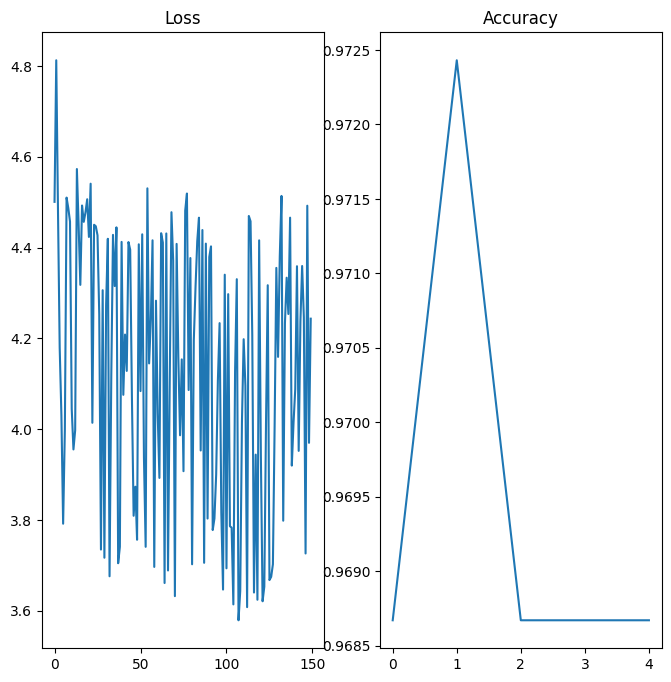

In [122]:
print(f"Score for alpha = {alpha}: {AccListM[-1]}")


plt.figure(1, figsize=(8, 8))
plt.subplot(121)
plt.plot(LossListM)
plt.title('Loss')
plt.subplot(122)
plt.plot(AccListM)
plt.title('Accuracy')
plt.show()

PCA

In [123]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Text(0.5, 0.98, 'Embeddings')

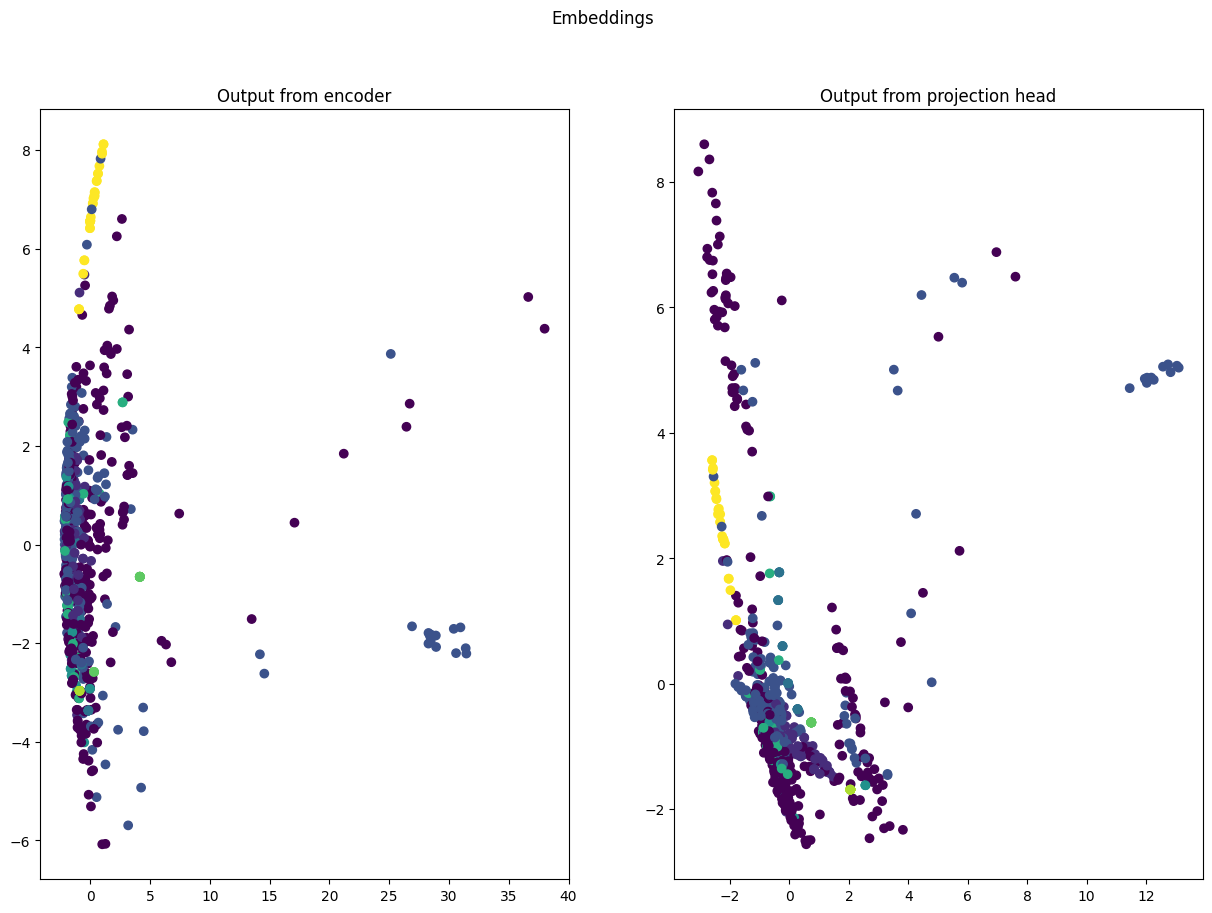

In [124]:
pca_model = PCA(n_components=2)
model.to("cpu")
with th.no_grad():
    embeddings = model.encoder(th.Tensor(x_te))
    embeddings_2 = model.proj_head(embeddings).numpy()
    embeddings_projected = pca_model.fit_transform(embeddings.numpy())
    embeddings_projected_2 = pca_model.fit_transform(embeddings_2)

fig, axs = plt.subplots(ncols=2, figsize=(15, 10))
axs[0].scatter(embeddings_projected[:, 0], embeddings_projected[:, 1], c=y_te)
axs[0].set_title("Output from encoder")
axs[1].scatter(embeddings_projected_2[:, 0], embeddings_projected_2[:, 1], c=y_te)
axs[1].set_title("Output from projection head")

plt.suptitle("Embeddings")

Text(0.5, 0.98, 'Embeddings')

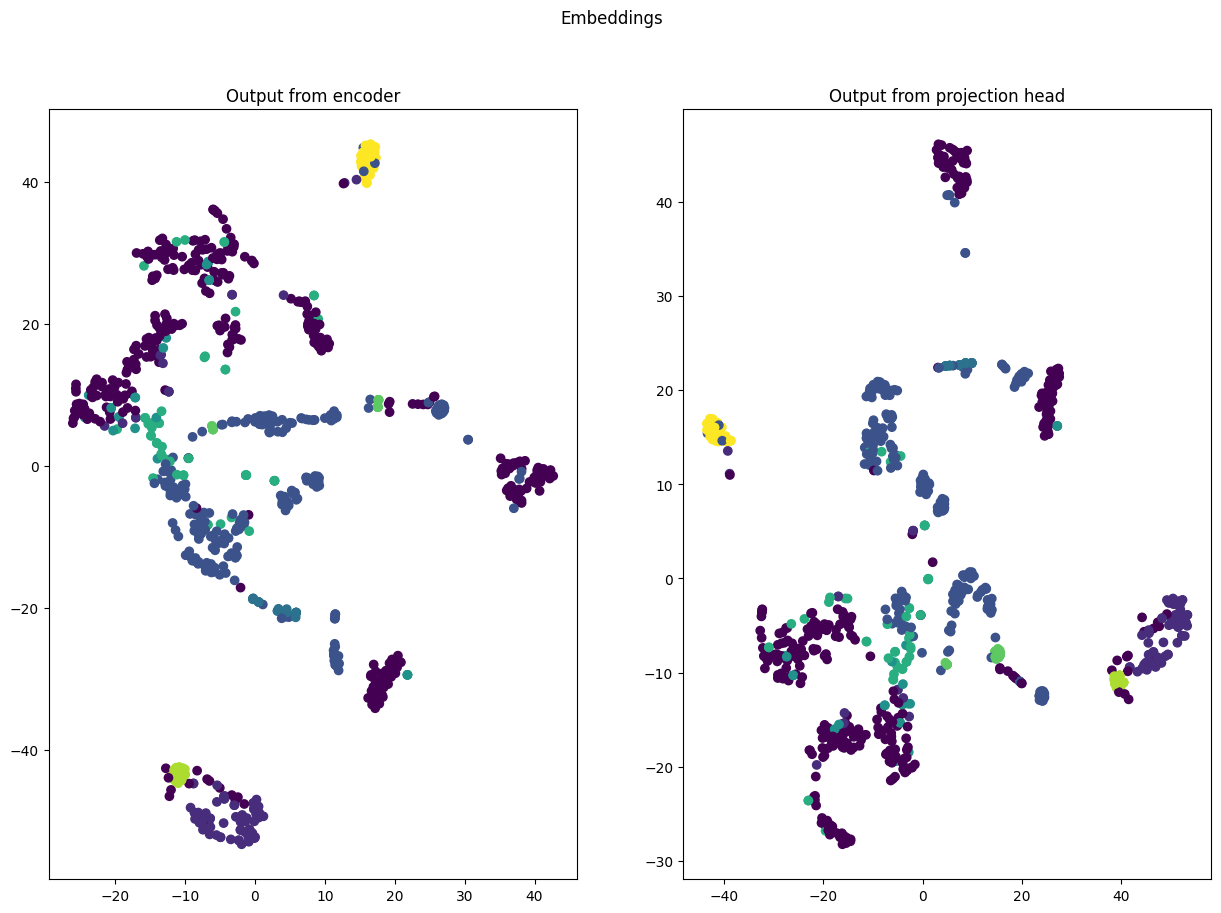

In [125]:
# t-SNE decomposition
tsne = TSNE(n_components=2)
embeddings_tsne = tsne.fit_transform(embeddings.numpy())
embeddings_tsne_2 = tsne.fit_transform(embeddings_2)

fig, axs = plt.subplots(ncols=2, figsize=(15, 10))
axs[0].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=y_te)
axs[0].set_title("Output from encoder")
axs[1].scatter(embeddings_tsne_2[:, 0], embeddings_tsne_2[:, 1], c=y_te)
axs[1].set_title("Output from projection head")

plt.suptitle("Embeddings")